# Demonstrate Transfer Learning and Tuning

Transfer Learning and Tuning demonstration on Cats and Dogs filtered dataset using <h3>MobileNetV2</h3>

![alt text](https://live.staticflickr.com/4544/38228876666_3782386ca7_b.jpg)

## Library Imports

In [1]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with little gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Load the image dataset

In [3]:
PARENT_DIR = os.environ.get("ONE_DRIVE")
DATA_DIR = 'Datasets/LargeDatasets/cats_and_dogs_filtered'
DATA_DIR = os.path.join(PARENT_DIR, DATA_DIR)
print(DATA_DIR)

D:\OneDrive\Datasets/LargeDatasets/cats_and_dogs_filtered


In [4]:
# Define the training and validation paths

train_dir = os.path.join(DATA_DIR, 'train')
validation_dir = os.path.join(DATA_DIR, 'validation')

# Directory for training images
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory for validation images
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Check the first five names of the cats ang dogs
cats_fnames = os.listdir(train_cats_dir)
dogs_fnames = os.listdir(validation_dogs_dir)

print(f"First 5 names of the cats training images - {cats_fnames[:5]}")
print(f"First 5 names of the dogs training images - {dogs_fnames[:5]}")

print(f"Total Training Cats Images - {len(os.listdir(train_cats_dir))}")
print(f"Total training dogs Images - {len(os.listdir(train_dogs_dir))}")
print(f"Total validation cats Images - {len(os.listdir(validation_cats_dir))}")
print(f"Total validation dogs Images - {len(os.listdir(validation_dogs_dir))}")

First 5 names of the cats training images - ['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg']
First 5 names of the dogs training images - ['dog.2000.jpg', 'dog.2001.jpg', 'dog.2002.jpg', 'dog.2003.jpg', 'dog.2004.jpg']
Total Training Cats Images - 1000
Total training dogs Images - 1000
Total validation cats Images - 500
Total validation dogs Images - 500


### Build the Image Data Generators

In [5]:
# we will preprocess the image, before we will apply the image to model for training
# Adding data augmentation parameters

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Note that validation data should not be augmented
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Flow training images in the batches of 20 using train datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='binary', target_size=(128, 128))

# Flow validation images in the batches of 20 using test datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size=20, class_mode='binary', target_size=(128, 128))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Building the Model
### Loading the pre-trained model (MobileNetV2)

In [6]:
IMAGE_SHAPE = (128, 128, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
base_model.summary()

# We would not take the top and output layer of the MobileNetV2 as it is explicitly trained for IMAGENET .. We would need to define a custom head for our specific task and hence we set it to False

9420800/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
________________

### Freezing the base model

In [7]:
# We don't want to re-train the base model again and would want to use its existing weights ,.. hence
base_model.trainable = False

# We will train only the layers which we will add for our custom task

### Defining the custom head for our network

Custom head is always designed fer the task, that we are going to solve

In [8]:
# First thing to do is to check, what is the output size from the base model
base_model.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

In [9]:
# This shape is not suitable for our task, we can resolve it by using Global average pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
global_average_layer

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

Now it is converted to size (Mone, 1280) - it has kept only the last dimension

In [10]:
# Now we will just add the output layer
prediction_layer = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid) (global_average_layer)

### Defining the Model

In [11]:
model = tf.keras.models.Model(inputs = base_model.input, outputs = prediction_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

### Compiling the Model

In [12]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

C:\Miniconda3\envs\tensorflow-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## Training the Model

In [13]:
model_fit = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
100/100 [==============================] - 40s 287ms/step - loss: 0.7208 - accuracy: 0.5950 - val_loss: 0.4582 - val_accuracy: 0.8210
Epoch 2/5
100/100 [==============================] - 12s 121ms/step - loss: 0.5036 - accuracy: 0.7620 - val_loss: 0.3136 - val_accuracy: 0.8920
Epoch 3/5
100/100 [==============================] - 12s 122ms/step - loss: 0.3769 - accuracy: 0.8490 - val_loss: 0.2401 - val_accuracy: 0.9250
Epoch 4/5
100/100 [==============================] - 12s 119ms/step - loss: 0.3165 - accuracy: 0.8800 - val_loss: 0.2005 - val_accuracy: 0.9310
Epoch 5/5
100/100 [==============================] - 12s 119ms/step - loss: 0.2724 - accuracy: 0.8955 - val_loss: 0.1752 - val_accuracy: 0.9400


## Transfer Learning model evaluation

In [14]:
validation_Loss , validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss - {validation_Loss}")
print(f"Validation Accuracy = {validation_accuracy}")

50/50 [==============================] - 2s 42ms/step - loss: 0.1752 - accuracy: 0.9400
Validation Loss - 0.1751691997051239
Validation Accuracy = 0.9399999976158142


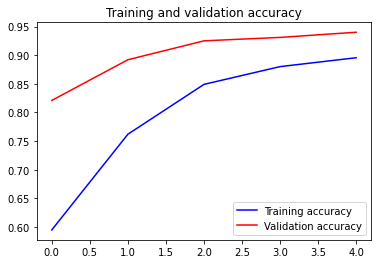

<Figure size 432x288 with 0 Axes>

In [15]:
# We will plot the training accuracy vs validation accuracy

acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

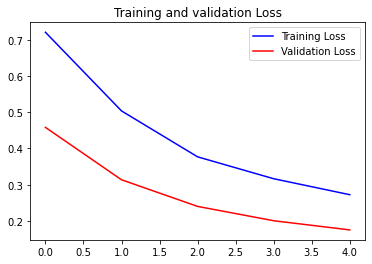

<Figure size 432x288 with 0 Axes>

In [16]:
# We will plot the training loss vs validation loss

loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()


plt.show()

## Fine Tuning

There are a few pointers:

- DO NOT use Fine tuning on the whole network; only a few top layers are enough. In most cases, they are more specialized. The goal of the Fine-tuning is to adopt that specific part of the network for our custom (new) dataset.
- Start with the fine tunning AFTER you have finished with transfer learning step. If we try to perform Fine tuning immediately, gradients will be much different between our custom head layer and a few unfrozen layers from the base model.

The base layers are goint to learn more atomic features like shape, edges etc and the top layers get trained on more abstract and high level features like - eyes, nose etc... So fine tuning at the top layers is necessary without disturbing the bottom layers

### Unfreeze Few top layers from the Model

In [17]:
base_model.trainable = True
print(f"Number of layers in the base model - {len(base_model.layers)}")

Number of layers in the base model - 154


In [18]:
fine_tune_at = 100 # index of the layer from which we are going to fine tune, which means we are going to fine tune all layers from 100 to 154

# remaining base layers are not to be trained
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### Compile the model for fine tuning

In [19]:
# We are basically recompiling the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

### Perform the fine tuning

In [20]:
model_fit = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
100/100 [==============================] - 18s 126ms/step - loss: 0.2791 - accuracy: 0.8805 - val_loss: 0.0925 - val_accuracy: 0.9630
Epoch 2/5
100/100 [==============================] - 12s 120ms/step - loss: 0.1883 - accuracy: 0.9145 - val_loss: 0.1100 - val_accuracy: 0.9560
Epoch 3/5
100/100 [==============================] - 12s 119ms/step - loss: 0.1562 - accuracy: 0.9380 - val_loss: 0.1762 - val_accuracy: 0.9390
Epoch 4/5
100/100 [==============================] - 12s 119ms/step - loss: 0.1352 - accuracy: 0.9440 - val_loss: 0.1308 - val_accuracy: 0.9590
Epoch 5/5
100/100 [==============================] - 12s 118ms/step - loss: 0.1163 - accuracy: 0.9550 - val_loss: 0.0943 - val_accuracy: 0.9710


In [21]:
validation_Loss , validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss - {validation_Loss}")
print(f"Validation Accuracy = {validation_accuracy}")

50/50 [==============================] - 2s 40ms/step - loss: 0.0943 - accuracy: 0.9710
Validation Loss - 0.09426131099462509
Validation Accuracy = 0.9710000157356262
